<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem-Overview" data-toc-modified-id="Problem-Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Problem Overview</a></span></li><li><span><a href="#Load-Dataset" data-toc-modified-id="Load-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Dataset</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Predictions" data-toc-modified-id="Predictions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Predictions</a></span></li></ul></div>

# Microsoft Malware Prediction


## Problem Overview

Challenge is to to predict if a machine will soon be hit with malware. 
 

## Load Dataset

In [48]:
# Load libraries

import numpy as np 
import pandas as pd 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import time
import lightgbm as lgb

**Save memory!**

The large dataset means we need to load the dataset as efficiently as possible.

Each column in train.csv has 9 million rows. If we declare a column as int16 then you allocate 2 bytes per each row equaling 18 million bytes (for that column). If you declare that column as int8 you allocate 1 byte per each row equaling 9 million bytes.

So we need to load each column into the least amount of memory possible!

There's a way to optimise for this,
- Load objects as categories.
- Binary values are switched to int8
- Binary values with missing values are switched to float16 (int does not understand nan)
- 64 bits encoding are all switched to 32, or 16 if possible
- This can be achieved using dtype parameter in read_csv to predefine the datatypes for each column

Reference: https://www.kaggle.com/theoviel/load-the-totality-of-the-data

In [3]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = [c for c,v in dtypes.items() if v in numerics]
categorical_columns = [c for c,v in dtypes.items() if v not in numerics]

In [8]:
# Load train data set
nrows = 400000
train = pd.read_csv('train.csv',nrows = nrows,dtype = dtypes)

In [9]:
train.memory_usage(deep=True).sum() #(gives results in bytes)

107206836

Without specifying dtypes - 20945096646  
After specifying dtypes - 

In [10]:
# Load test data set
test = pd.read_csv('test.csv',dtype = dtypes)

In [11]:
print("Number of rows and columns in train set : ",train.shape)
print("Number of rows and columns in test set : ",test.shape)

Number of rows and columns in train set :  (400000, 83)
Number of rows and columns in test set :  (7853253, 82)


In [14]:
train.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,...,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,...,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,...,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447.0,...,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0,7.0,0,NaN,53447.0,...,19844.0,0,0.0,0.0,0,0,0.0,0.0,1.0,1


## Exploratory Data Analysis

Now let us look at high level descriptive information about the dataset.

In [15]:
stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
28,PuaMode,1,99.97350,99.97350,category
41,Census_ProcessorClass,3,99.57300,99.57300,category
8,DefaultBrowsersIdentifier,477,95.17425,95.17425,float16
68,Census_IsFlightingInternal,2,83.01000,83.01000,float16
52,Census_InternalBatteryType,28,71.02950,71.02950,category
71,Census_ThresholdOptIn,2,63.51075,63.51075,float16
75,Census_IsWIMBootEnabled,1,63.42475,63.42475,float16
31,SmartScreen,12,35.68375,48.30600,category
15,OrganizationIdentifier,43,30.82850,47.11825,float16
29,SMode,2,5.96925,93.98825,float16


We can see several interesting things here:

- PuaMode and Census_ProcessorClass have 99%+ missing values, which means that these columns are useless and can be dropped
- Some columns have more that 99% of the values belonging to one category, so I think these columns are also useless
- Lot of columns have only two unique values with might indicate that they are binary


In [13]:
# Remove columns which has over 90% of values belonging to one category
good_cols = list(train.columns)
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)

In [14]:
train = train[good_cols]

Among the numerical variables, many corresponds to identifiers. In the current dataset, the truly numerical variables are in fact rare. Below, I make a list of the variables which are truly numerical, according the the description of the data.

https://www.kaggle.com/c/microsoft-malware-prediction/data

In [16]:
true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges'
]

In [17]:
#We also list binary variables, since they can be treated as numericals by tree methods:

binary_variables = [c for c in train.columns if train[c].nunique() == 2]

In [19]:
#to finally make a census of the categorical variables:

categorical_columns = [c for c in train.columns 
                       if (c not in true_numerical_columns) & (c not in binary_variables)]

In [ ]:
#ax = sns.barplot(x="day", y="total_bill", data=tips)

## LightGBM 

In [28]:
target = train['HasDetections']
del train['HasDetections']

In [20]:
param = {'num_leaves': 60,
         'min_data_in_leaf': 60, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 10,
         "verbosity": -1}

In [58]:
folds = KFold(n_splits=5, shuffle=True, random_state=10)
oof = np.zeros(len(train)) #simply stands for "Out-of-fold"
start = time.time()
categorical_columns = [c for c in categorical_columns if c not in ['MachineIdentifier']] #removing unique machine id 
features = [c for c in train.columns if c not in ['MachineIdentifier']]
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()
score = [0 for _ in range(folds.n_splits)]

#80% train 20% test

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)): 
    print("fold n{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature = categorical_columns)
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature = categorical_columns)
    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    #Activates early stopping. The model will train until the validation score stops improving. 
    #Validation score needs to improve at least every early_stopping_rounds round(s) to continue training. 
    #Requires at least one validation data and one metric. If there’s more than one, will check all of them. 
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    # we perform predictions by chunks
    initial_idx = 0
    chunk_size = 1000000
    current_pred = np.zeros(len(test))
    while initial_idx < test.shape[0]:
        final_idx = min(initial_idx + chunk_size, test.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = clf.predict(test.iloc[idx][features], num_iteration=clf.best_iteration)
        initial_idx = final_idx
    predictions += current_pred / min(folds.n_splits, max_iter)
   
    print("time elapsed: {:<5.2}s".format((time.time() - start) / 3600))
    score[fold_] = metrics.roc_auc_score(target.iloc[val_idx], oof[val_idx])
    

print("CV score: {:<8.5f}".format(np.mean(score) ))     
    

fold n0


C:\Users\newton\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\newton\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.81003	valid_1's auc: 0.690516
[200]	training's auc: 0.84641	valid_1's auc: 0.687256
Early stopping, best iteration is:
[29]	training's auc: 0.76226	valid_1's auc: 0.698423
time elapsed: 0.042s
fold n1


C:\Users\newton\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\newton\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.809868	valid_1's auc: 0.692506
[200]	training's auc: 0.847458	valid_1's auc: 0.689886
Early stopping, best iteration is:
[35]	training's auc: 0.769783	valid_1's auc: 0.698593
time elapsed: 0.091s
fold n2


C:\Users\newton\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\newton\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.811416	valid_1's auc: 0.694841
[200]	training's auc: 0.847499	valid_1's auc: 0.691965
Early stopping, best iteration is:
[30]	training's auc: 0.763785	valid_1's auc: 0.701239
time elapsed: 0.14 s
fold n3


C:\Users\newton\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\newton\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.809785	valid_1's auc: 0.692936
[200]	training's auc: 0.848029	valid_1's auc: 0.689505
Early stopping, best iteration is:
[27]	training's auc: 0.75992	valid_1's auc: 0.699952
time elapsed: 0.18 s
fold n4


C:\Users\newton\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\newton\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.811137	valid_1's auc: 0.692166
[200]	training's auc: 0.846882	valid_1's auc: 0.689262
Early stopping, best iteration is:
[28]	training's auc: 0.761337	valid_1's auc: 0.700112
time elapsed: 0.23 s
CV score: 0.69966 


In [59]:
print("CV score: {:<8.5f}".format(np.mean(score) ))    

CV score: 0.69966 


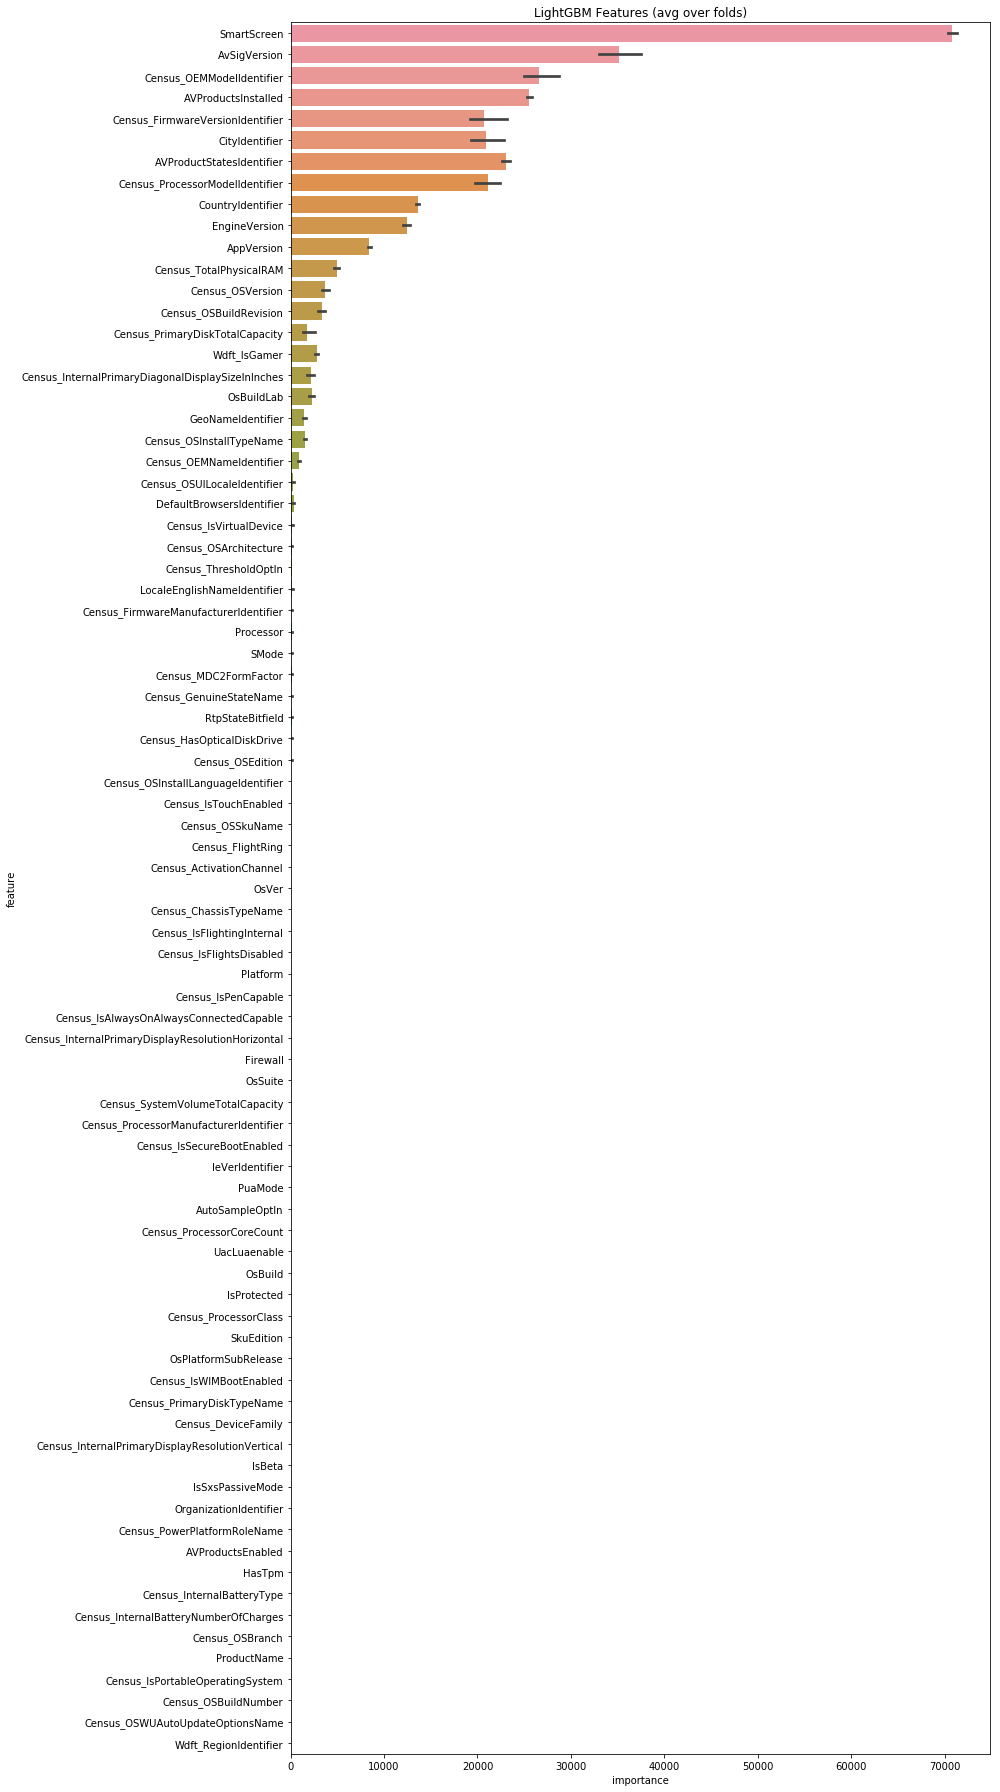

In [80]:
plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=feature_importance_df.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

## Predictions

In [81]:
sub_df = pd.DataFrame({"MachineIdentifier": test["MachineIdentifier"].values})
sub_df["HasDetections"] = predictions
sub_df[:10]

,MachineIdentifier,HasDetections
0,0000010489e3af074adeac69c53e555e,0.528120
1,00000176ac758d54827acd545b6315a5,0.584922
2,0000019dcefc128c2d4387c1273dae1d,0.394812
3,0000055553dc51b1295785415f1a224d,0.310885
4,00000574cefffeca83ec8adf9285b2bf,0.478403
5,000007ffedd31948f08e6c16da31f6d1,0.384366
6,000008f31610018d898e5f315cdf1bd1,0.296117
7,00000a3c447250626dbcc628c9cbc460,0.398192
8,00000b6bf217ec9aef0f68d5c6705897,0.506360
9,00000b8d3776b13e93ad83676a28e4aa,0.252995


In [82]:
sub_df.to_csv("submit.csv", index=False)